In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/LUNA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,1.18,1.32,1.18,1.25,1.25,11700
1,1/3/2013,1.22,1.24,1.16,1.17,1.17,15800
2,1/4/2013,1.18,1.23,1.18,1.22,1.22,5600
3,1/7/2013,1.22,1.22,1.20,1.22,1.22,2500
4,1/8/2013,1.24,1.32,1.20,1.30,1.30,8500


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 106.859999.3, cost: 0.000022, total money: 9989.019999
epoch: 20, total rewards: 138.120000.3, cost: 0.000121, total money: 10048.560000
epoch: 30, total rewards: 42.630000.3, cost: 0.000240, total money: 9909.890000
epoch: 40, total rewards: 110.129997.3, cost: 0.000043, total money: 10030.919998
epoch: 50, total rewards: 18.739998.3, cost: 0.000048, total money: 10018.739998
epoch: 60, total rewards: 121.969999.3, cost: 0.000069, total money: 10072.259999
epoch: 70, total rewards: 10.900000.3, cost: 0.000096, total money: 9996.170000
epoch: 80, total rewards: 6.990003.3, cost: 0.000025, total money: 10006.990003
epoch: 90, total rewards: -12.070000.3, cost: 0.000003, total money: 9973.150000
epoch: 100, total rewards: 15.000001.3, cost: 0.000068, total money: 10015.000001
epoch: 110, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 1.270000, total balance 9998.730000
day 17, sell 1 unit at price 1.320000, investment 3.937014 %, total balance 10000.050000,
day 25: buy 1 unit at price 1.220000, total balance 9998.830000
day 28: buy 1 unit at price 1.270000, total balance 9997.560000
day 31, sell 1 unit at price 1.210000, investment -0.819671 %, total balance 9998.770000,
day 37: buy 1 unit at price 1.190000, total balance 9997.580000
day 39, sell 1 unit at price 1.170000, investment -7.874018 %, total balance 9998.750000,
day 41: buy 1 unit at price 1.250000, total balance 9997.500000
day 47, sell 1 unit at price 1.330000, investment 11.764704 %, total balance 9998.830000,
day 54: buy 1 unit at price 1.350000, total balance 9997.480000
day 58: buy 1 unit at price 1.300000, total balance 9996.180000
day 59, sell 1 unit at price 1.260000, investment 0.799999 %, total balance 9997.440000,
day 60: buy 1 unit at price 1.190000, total balance 9996.250000
day 62, sell 1 unit at price 1.210000, 

day 585: buy 1 unit at price 1.370000, total balance 9963.010000
day 587, sell 1 unit at price 1.350000, investment -18.674696 %, total balance 9964.360000,
day 595, sell 1 unit at price 1.220000, investment -12.857139 %, total balance 9965.580000,
day 596: buy 1 unit at price 1.280000, total balance 9964.300000
day 597, sell 1 unit at price 1.270000, investment -7.299272 %, total balance 9965.570000,
day 600: buy 1 unit at price 1.150000, total balance 9964.420000
day 602, sell 1 unit at price 1.150000, investment -17.266188 %, total balance 9965.570000,
day 603: buy 1 unit at price 1.130000, total balance 9964.440000
day 605: buy 1 unit at price 1.150000, total balance 9963.290000
day 611, sell 1 unit at price 1.140000, investment -17.985612 %, total balance 9964.430000,
day 614, sell 1 unit at price 1.110000, investment -15.267171 %, total balance 9965.540000,
day 615: buy 1 unit at price 1.090000, total balance 9964.450000
day 620, sell 1 unit at price 1.050000, investment -27.0833

day 909, sell 1 unit at price 1.180000, investment 35.632177 %, total balance 9978.710000,
day 913, sell 1 unit at price 1.090000, investment -6.837601 %, total balance 9979.800000,
day 917: buy 1 unit at price 1.200000, total balance 9978.600000
day 918: buy 1 unit at price 1.170000, total balance 9977.430000
day 923, sell 1 unit at price 1.200000, investment 14.285724 %, total balance 9978.630000,
day 924: buy 1 unit at price 1.190000, total balance 9977.440000
day 925: buy 1 unit at price 1.140000, total balance 9976.300000
day 931: buy 1 unit at price 1.440000, total balance 9974.860000
day 932, sell 1 unit at price 1.430000, investment 32.407397 %, total balance 9976.290000,
day 934, sell 1 unit at price 1.450000, investment 34.259258 %, total balance 9977.740000,
day 938, sell 1 unit at price 1.560000, investment 41.818174 %, total balance 9979.300000,
day 949: buy 1 unit at price 1.430000, total balance 9977.870000
day 954: buy 1 unit at price 1.350000, total balance 9976.520000

day 1493, sell 1 unit at price 3.420000, investment 33.593756 %, total balance 9994.519999,
day 1498, sell 1 unit at price 3.100000, investment -2.208207 %, total balance 9997.619999,
day 1501, sell 1 unit at price 2.960000, investment -8.359132 %, total balance 10000.579999,
day 1502, sell 1 unit at price 3.000000, investment -7.692308 %, total balance 10003.579999,
day 1506, sell 1 unit at price 2.920000, investment -1.351350 %, total balance 10006.499999,
day 1508: buy 1 unit at price 3.180000, total balance 10003.319999
day 1510, sell 1 unit at price 3.350000, investment 1.515150 %, total balance 10006.669999,
day 1516: buy 1 unit at price 3.400000, total balance 10003.269999
day 1520: buy 1 unit at price 3.400000, total balance 9999.869999
day 1533, sell 1 unit at price 3.290000, investment 11.525421 %, total balance 10003.159999,
day 1535, sell 1 unit at price 3.170000, investment 7.457628 %, total balance 10006.329999,
day 1542, sell 1 unit at price 3.170000, investment 7.457628

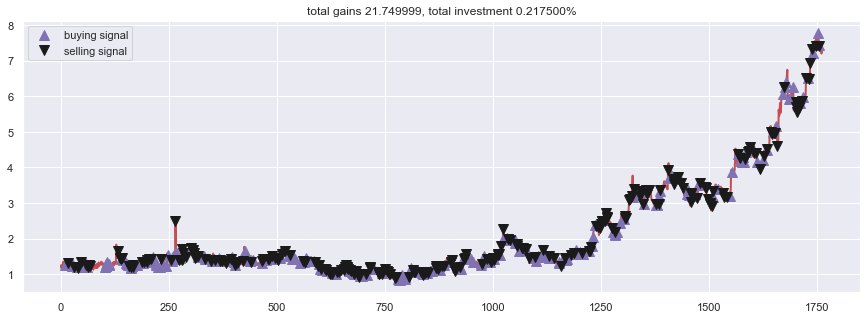

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()